In [1]:
import matplotlib.pyplot as plt
import numpy as np
import filterpy.stats as stats

### Prediction with Gaussians - Sum of Two Gaussians

In [2]:
from collections import namedtuple

Gaussian Tuple

In [3]:
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

In [4]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


In [5]:
def predict(pos, movement):
    return gaussian(pos.mean+movement.mean, pos.var+movement.var)

In [6]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

### Updation with Gaussians - Multiplication of Two Gaussians

In [7]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

In [8]:
def update(prior, likelihood):
    return gaussian_multiply(prior, likelihood)

In [10]:
# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

Note: Gaussians Multiplication

𝒩(μ=10.000, 𝜎²=0.500)


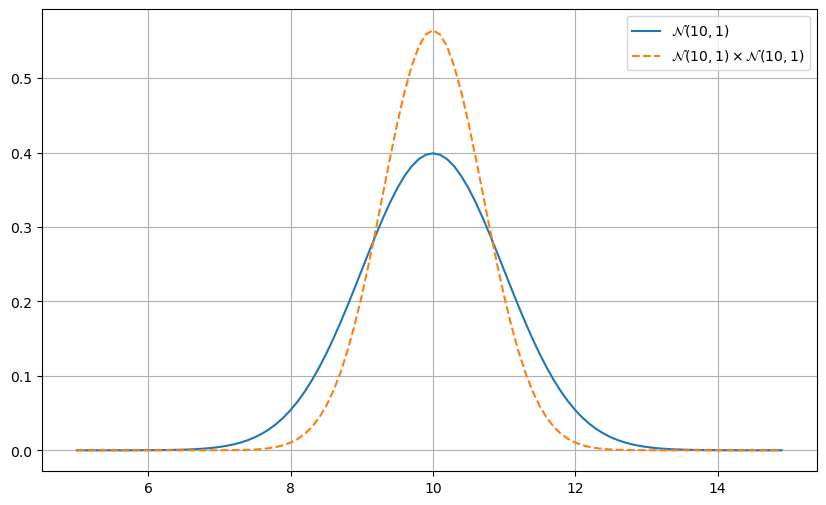

In [21]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)

plt.figure(figsize=(10, 6))
plt.grid()
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\\mathcal{N}(10,1) \\times \\mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

<Figure size 640x480 with 0 Axes>

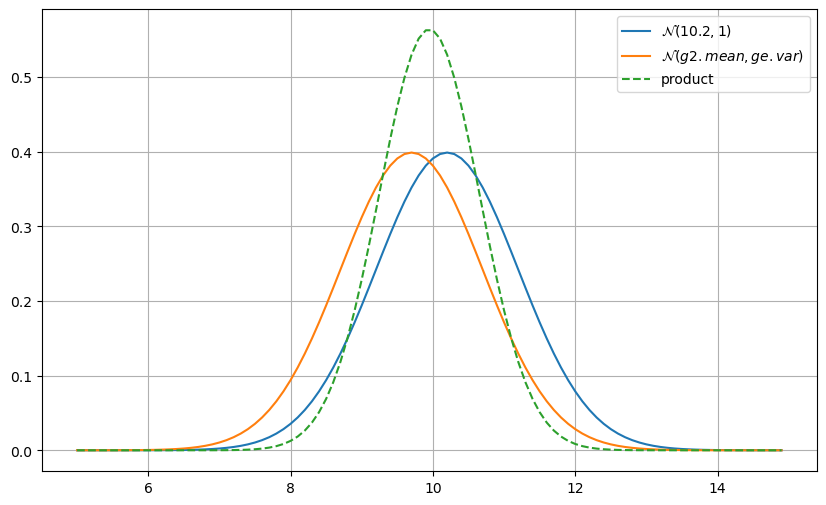

In [23]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    plt.figure(figsize=(10, 6))
    plt.grid()
    
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\\mathcal{N}$' + f'$({g1.mean},{g1.var})$')

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\\mathcal{N}$' + '$({g2.mean},{ge.var})$')

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    
    plt.legend()
    plt.show()
    
z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
 
plot_products(z1, z2)

In [9]:
from ipywidgets import interact

In [27]:
def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1))

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

<function __main__.interactive_gaussian(m1, m2, v1, v2)>

### Kalman Filter

Simulation

In [10]:
from lib.simulation.DogSimulation import DogSimulation

In [12]:
np.random.seed(20)

process_var = 1.0
sensor_var = 2.0

x = gaussian(0.0, 20.0**2)
velocity = 1
dt = 1.0
process_model = gaussian(velocity * dt, process_var)

dog = DogSimulation(
    x0=x.mean,
    velocity=process_model.mean,
    measurement_var=sensor_var,
    process_var=process_model.var,
)

zs = [dog.move_and_sense() for _ in range(10)]

KF

In [11]:
import lib.kf_book.kf_internal as kf_internal

In [15]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    
    kf_internal.print_gh(prior, x, z)

print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	2.161	  2.155   1.990
  3.155    2.990	-0.072	  1.221   1.198
  2.221    2.198	3.948	  3.125   1.047
  4.125    2.047	3.712	  3.916   1.012
  4.916    2.012	7.174	  6.048   1.003
  7.048    2.003	7.225	  7.137   1.001
  8.137    2.001	6.939	  7.538   1.000
  8.538    2.000	8.199	  8.368   1.000
  9.368    2.000	11.024	 10.196   1.000
 11.196    2.000	11.433	 11.314   1.000

final estimate:            11.314
actual final position:     10.858


In [18]:
from lib.kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…

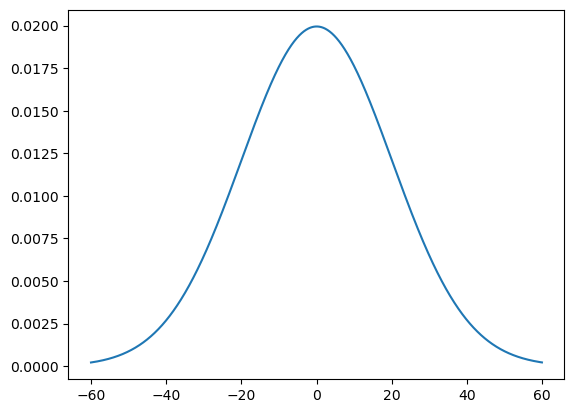

In [20]:
xs = np.arange(-60, 60, 0.1)
ys = [stats.gaussian(x, 0, 20.**2) for x in xs]
plt.plot(xs, ys, label='$\\mathcal{N}$' + f'$({0},{20.**2})$')


	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


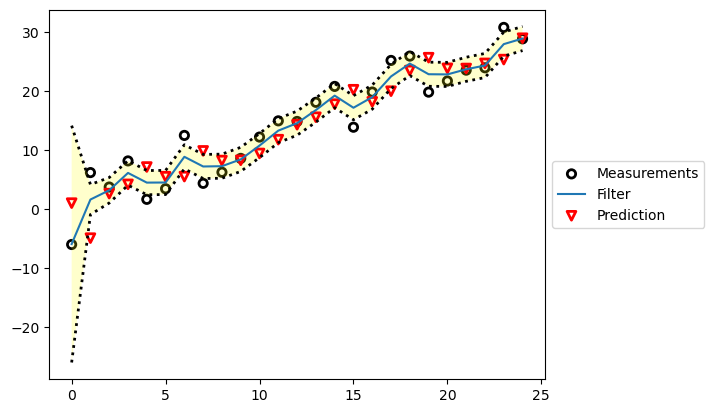

In [21]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

### thermometer

In [13]:
from lib.kf_book import book_plots

In [11]:
def volt(voltage, std):
    return voltage + (np.random.randn() * std)

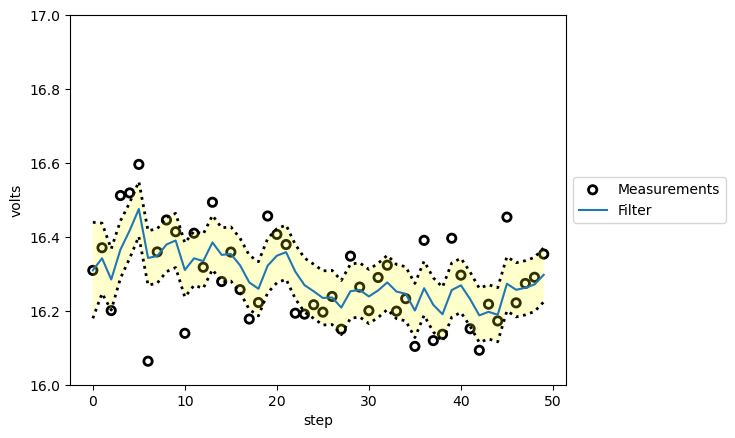

Variance converges to 0.005


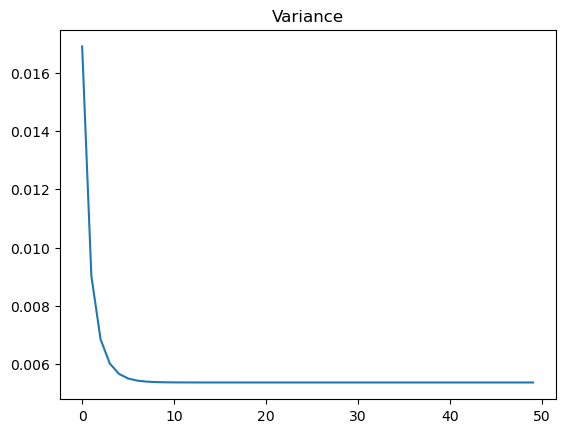

In [14]:
temp_change = 0
voltage_std = .13
process_var = .05**2
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
zs = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

for z in zs:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

# plot the filter output and the variance
book_plots.plot_measurements(zs)
book_plots.plot_filter(estimates, var=np.array(ps))
book_plots.show_legend()
plt.ylim(16, 17)
book_plots.set_labels(x='step', y='volts')
plt.show()
    
plt.plot(ps)
plt.title('Variance')
print(f'Variance converges to {ps[-1]:.3f}')

Note: Bayesian Approach & Residual Approach to interprete scaling factor $g$

> The key point is to recognize that math requires that the variances correctly describe your system. The filter does not 'notice' that it is diverging from the measurements and correct itself. It computes the Kalman gain from the variance of the prior and the measurement, and forms the estimate depending on which is more accurate.

Three variance in the problem: initial state & process noise & sensor noise

### Large noise and bad initialization

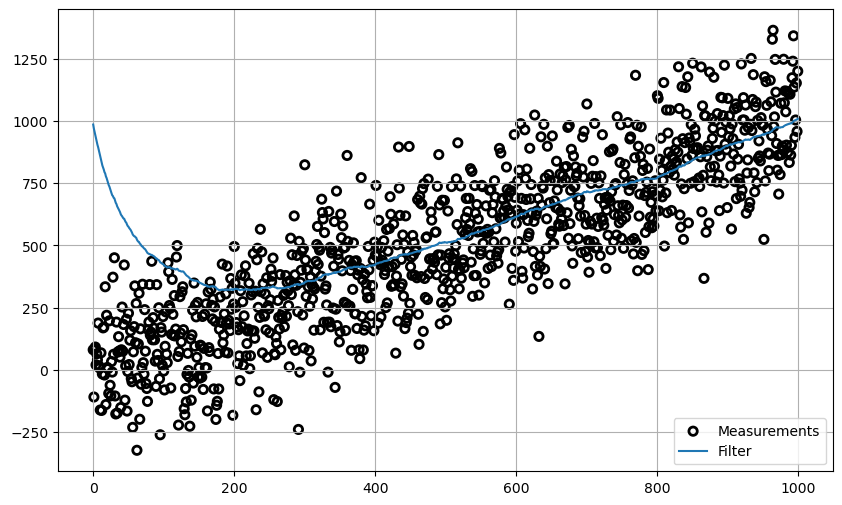

In [15]:
sensor_var = 30000.
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)

N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

plt.figure(figsize=(10, 6))
plt.grid()
book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4)

After first iteration, the predicted value should be 1000+1 (bad initial state + velocity*dt), and the incorporated measurement is $Gaussian=(0, 30000.)$, notice the sensor mean is still 0 no matter bad initial state, because we extracted from a real dog simulation initial state, 0. 

Nevertheless the estimated value will be drag to align the measurement, it is just so slow since we also bear a low confidence on sensor.

In [21]:
from ipywidgets import interact
from lib.kf_book.book_plots import FloatSlider
from numpy.random import seed

In [24]:
def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity, 
                       process_noise):
    seed(101)
    
    pos = gaussian(0., 1000.)
    process_model = gaussian(velocity, process_noise)
    
    N = 100
    dog = DogSimulation(start_pos, velocity, sensor_noise, process_noise)
    zs, ps = [dog.move_and_sense() for _ in range(N)], []
    
    for z in zs:
        prior = predict(pos, process_model)
        pos = update(prior, gaussian(z, sensor_noise))
        ps.append(pos.mean)
        
    plt.figure(figsize=(10, 6))
    plt.plot(zs, c='k', marker='o', linestyle='', label='measurement')
    plt.plot(ps, c='#004080', alpha=0.7, label='filter')
    plt.legend(loc=4)
    plt.show()
    
interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0, max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=5, min=0, max=100.));

interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…